In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200,
    "axes.titlesize": 18,
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+deviations))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"аппроксимация функцией {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    indent = 0.05   # отступ по бокам от области экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*indent, b+(b-a)*indent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.minorticks_on()
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    # plt.autoscale(tight=True)
    plt.locator_params(axis='x', nbins=14, tight=True)
    plt.locator_params(axis='y', nbins=12, tight=True)
    plt.xlabel(fr"{xname}, {xunit}")
    plt.ylabel(fr"{yname}, {yunit}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

Tensorflow при этом утилизирует примерно 85% cpu, а pennylane только 50%

qsim внутри pennylane вообще только одно из 16 ядер утилизировал

In [18]:
results = [["pennylane.csv", "pennylane-lightning"], 
           ['tensorflow.csv', "tensorflow"],
           ["pennylane_default.csv", 'pennylane-python'],
           ["pennylane_qsim.csv", "pennylane-qsim(tfq)"]]

In [19]:
visApproxError = True   # рисовать ли область ошибки аппроксимации
xname, xunit = r"N_qubits", ""
yname, yunit = r"200 opt steps time", "ms"


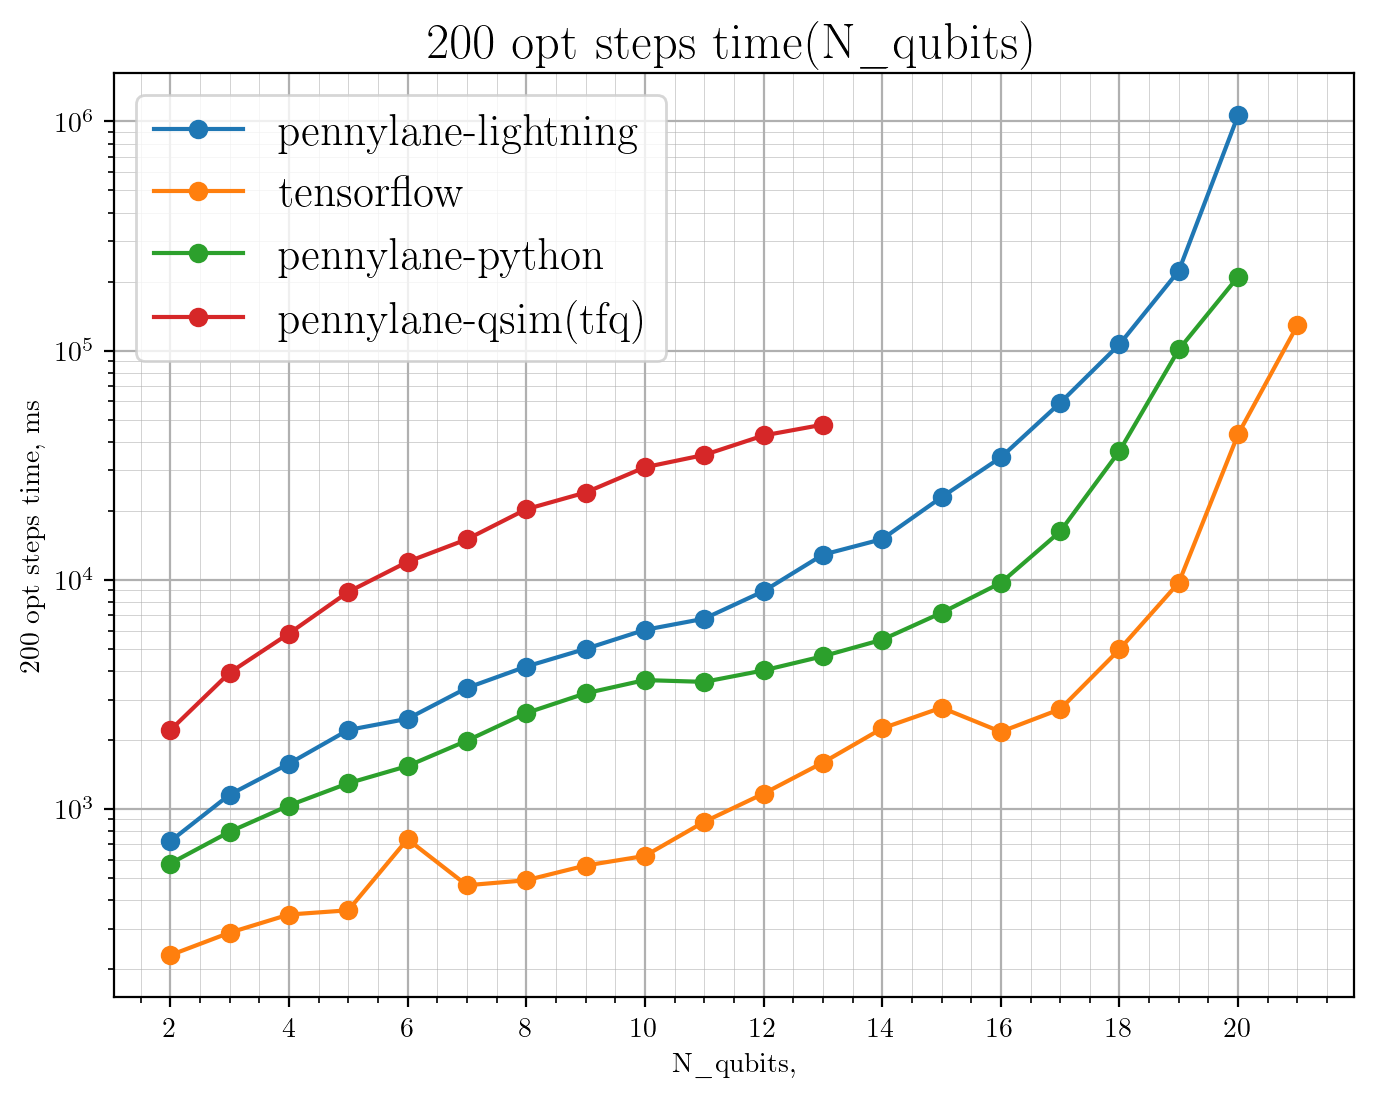

In [20]:
for file_name, label in results:
    df = pd.read_csv(file_name)
    x = df["n_qubits"]
    y = df['time[ms]']

    plt.errorbar(x, y, fmt="o-", xerr=None, yerr=None, label=label, capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)
plt.yscale('log')

plt.legend(fontsize=16)
if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"{time_string()}.jpg"), dpi=300)